In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

import xgboost
import graphviz

RANDOM_SEED = 1212

## Data Loading

In [3]:
train = pd.read_csv('../data/small/train/orange_small_train.data', sep="\t")
train.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1526.0,7.0,NaN,NaN,NaN,...,oslk,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,525.0,0.0,NaN,NaN,NaN,...,oslk,2Kb5FSF,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,5236.0,7.0,NaN,NaN,NaN,...,Al6ZaUT,NKv4yOc,jySVZNlOJy,NaN,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,...,oslk,CE7uk3u,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,1029.0,7.0,NaN,NaN,NaN,...,oslk,1J2cvxe,LM8l689qOp,NaN,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86,NaN


In [4]:
upselling_label = (
    pd.read_csv(
        "../data/small/labels/orange_small_train_upselling.labels", sep="\t", header=None
    )
    .iloc[:, 0]
    .astype("category")
)

upselling_label.cat.rename_categories([0, 1], inplace=True)

upselling_label.head()

0    0
1    0
2    0
3    0
4    0
Name: 0, dtype: category
Categories (2, int64): [0, 1]

## Dataframe Conversion

In [5]:
def convert_dataframe(DF):
    df_var_names = DF.columns

    df_types = {df_var_name: DF[df_var_name].dtype for df_var_name in df_var_names}

    for df_var_name in df_var_names:
        if df_types[df_var_name] == int:
            df = DF[df_var_name].astype(float)
            DF.loc[:, df_var_name] = df
            df_types[df_var_name] = df.dtype

        elif df_types[df_var_name] != float:
            df = DF[df_var_name].astype("category")
            DF.loc[:, df_var_name] = df
            df_types[df_var_name] = df.dtype

    return DF, df_types

In [6]:
train, train_types = convert_dataframe(train)

## Data Cleaning and Filling

In [7]:
def plot_missing_data(train):
    train_missing = train.isnull().sum() / train.shape[0]

    plt.figure(figsize=(15,5))
    
    plt.hist(train_missing, bins=50)

    plt.title("Missing data proportions on Train set")
    plt.show()

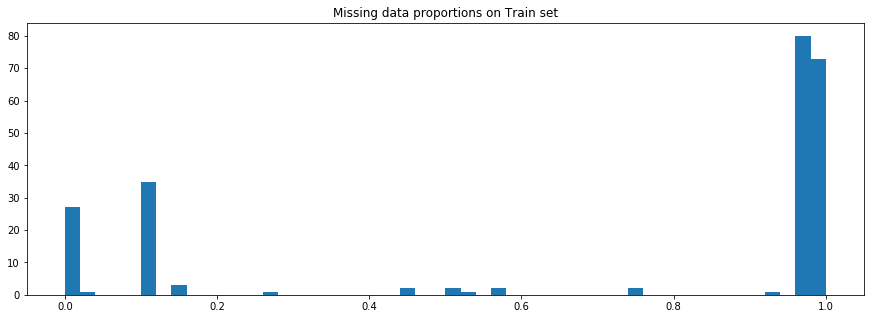

In [8]:
plot_missing_data(train)

I'll consider valid only features that have less than 15% missing data of its total data as our model features

In [9]:
train_missing = train.isnull().sum() / train.shape[0]
features = train_missing[train_missing <= 0.15].index

print(features)
print(len(features))

Index(['Var6', 'Var7', 'Var13', 'Var21', 'Var22', 'Var24', 'Var25', 'Var28',
       'Var35', 'Var38', 'Var44', 'Var57', 'Var65', 'Var73', 'Var74', 'Var76',
       'Var78', 'Var81', 'Var83', 'Var85', 'Var109', 'Var112', 'Var113',
       'Var119', 'Var123', 'Var125', 'Var132', 'Var133', 'Var134', 'Var140',
       'Var143', 'Var144', 'Var149', 'Var153', 'Var160', 'Var163', 'Var173',
       'Var181', 'Var192', 'Var193', 'Var195', 'Var196', 'Var197', 'Var198',
       'Var199', 'Var202', 'Var203', 'Var204', 'Var205', 'Var206', 'Var207',
       'Var208', 'Var210', 'Var211', 'Var212', 'Var216', 'Var217', 'Var218',
       'Var219', 'Var220', 'Var221', 'Var222', 'Var223', 'Var226', 'Var227',
       'Var228'],
      dtype='object')
66


Filling the missing numeric values with respective column mean values

In [10]:
numeric_features = [feat for feat in features if train_types[feat] == float]

print(numeric_features)
print(len(numeric_features))

['Var6', 'Var7', 'Var13', 'Var21', 'Var22', 'Var24', 'Var25', 'Var28', 'Var35', 'Var38', 'Var44', 'Var57', 'Var65', 'Var73', 'Var74', 'Var76', 'Var78', 'Var81', 'Var83', 'Var85', 'Var109', 'Var112', 'Var113', 'Var119', 'Var123', 'Var125', 'Var132', 'Var133', 'Var134', 'Var140', 'Var143', 'Var144', 'Var149', 'Var153', 'Var160', 'Var163', 'Var173', 'Var181']
38


In [11]:
train[numeric_features] = train[numeric_features].fillna(
    train[numeric_features].mean()
)

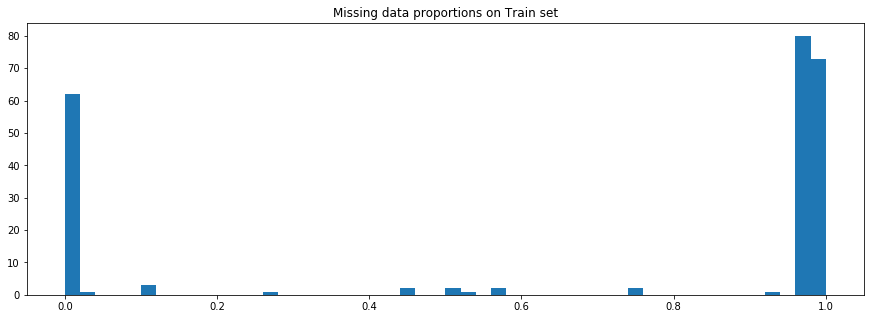

In [12]:
plot_missing_data(train)

I'll now remove the categorical features that have more than 400 categories in it

In [13]:
categorical_features = [feat for feat in features if train_types[feat] != float]

print(categorical_features)
print(len(categorical_features))

['Var192', 'Var193', 'Var195', 'Var196', 'Var197', 'Var198', 'Var199', 'Var202', 'Var203', 'Var204', 'Var205', 'Var206', 'Var207', 'Var208', 'Var210', 'Var211', 'Var212', 'Var216', 'Var217', 'Var218', 'Var219', 'Var220', 'Var221', 'Var222', 'Var223', 'Var226', 'Var227', 'Var228']
28


In [14]:
categorical_levels = train[categorical_features].apply(lambda col: len(col.cat.categories))

categorical_features_filtered = categorical_levels[categorical_levels <= 400].index.tolist()
print(categorical_features_filtered)
print(len(categorical_features_filtered))

['Var192', 'Var193', 'Var195', 'Var196', 'Var197', 'Var203', 'Var204', 'Var205', 'Var206', 'Var207', 'Var208', 'Var210', 'Var211', 'Var212', 'Var218', 'Var219', 'Var221', 'Var223', 'Var226', 'Var227', 'Var228']
21


In [15]:
features_filtered = numeric_features + categorical_features_filtered
print(features_filtered)
print(len(features_filtered))

['Var6', 'Var7', 'Var13', 'Var21', 'Var22', 'Var24', 'Var25', 'Var28', 'Var35', 'Var38', 'Var44', 'Var57', 'Var65', 'Var73', 'Var74', 'Var76', 'Var78', 'Var81', 'Var83', 'Var85', 'Var109', 'Var112', 'Var113', 'Var119', 'Var123', 'Var125', 'Var132', 'Var133', 'Var134', 'Var140', 'Var143', 'Var144', 'Var149', 'Var153', 'Var160', 'Var163', 'Var173', 'Var181', 'Var192', 'Var193', 'Var195', 'Var196', 'Var197', 'Var203', 'Var204', 'Var205', 'Var206', 'Var207', 'Var208', 'Var210', 'Var211', 'Var212', 'Var218', 'Var219', 'Var221', 'Var223', 'Var226', 'Var227', 'Var228']
59


Feature Selection

In [16]:
train = train[features_filtered]

Getting dummy variables for category columns

In [17]:
train = pd.get_dummies(train, dtype=bool)

Scaling between $[0,1]$ numeric features

In [18]:
scaler = MinMaxScaler()
train[numeric_features] = scaler.fit_transform(train[numeric_features])

In [19]:
train.head()

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,...,Var228__URKn_77G3QyQHSVQ2N1RKmtW,Var228__cTCyH95OE93jSkoIBT,Var228_am14IcfM7tWLrUmRT52KtA,Var228_b9qbUNk0dML_Mvi2,Var228_d0LtHjWeaXyArdN4sxU_saXqH,Var228_ib5G6X1eUxUn6,Var228_iyHGyLCEkQ,Var228_n1OBWGkV3fbsHR75taC,Var228_r_7E,Var228_xwM2aC7IdeMC0
0,0.011582,0.05,0.000930,0.012792,0.012792,0.028340,0.009721,0.044674,0.0,0.000189,...,False,False,False,False,False,False,False,False,False,False
1,0.003984,0.00,0.000000,0.004632,0.004632,0.004049,0.001823,0.080453,0.0,0.252825,...,False,False,False,False,False,False,False,False,False,False
2,0.039739,0.05,0.004569,0.033414,0.033414,0.052632,0.061968,0.054916,0.0,0.312194,...,False,False,False,False,False,True,False,False,False,False
3,0.010067,0.00,0.000000,0.006466,0.000000,0.009125,0.000000,0.017024,0.0,0.000000,...,False,False,False,False,False,False,False,False,False,False
4,0.007810,0.05,0.016253,0.001764,0.001764,0.008097,0.004860,0.051073,0.0,0.000000,...,False,False,False,False,False,False,False,False,False,False


## Train, Validation and Test split

In [20]:
x_train, x_test, y_train, y_test = train_test_split(
    train, upselling_label, test_size=0.2, random_state=RANDOM_SEED
)

x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=RANDOM_SEED
)

In [21]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(32000, 1031)
(8000, 1031)
(10000, 1031)


## Model Training

### XGBoost Classifier

In [22]:
xgb = xgboost.XGBClassifier(
    n_jobs=8,
    learning_rate=0.01,
    max_depth=10,
    n_estimators=2000,
    random_state=RANDOM_SEED,
)

In [23]:
xgb.fit(
    x_train,
    y_train,
    eval_set=[(x_val, y_val)],
    early_stopping_rounds=50,
    eval_metric="auc",
    verbose=True,
)

[0]	validation_0-auc:0.73858
Will train until validation_0-auc hasn't improved in 50 rounds.
[1]	validation_0-auc:0.738389
[2]	validation_0-auc:0.737413
[3]	validation_0-auc:0.736916
[4]	validation_0-auc:0.736712
[5]	validation_0-auc:0.736563
[6]	validation_0-auc:0.736927
[7]	validation_0-auc:0.7357
[8]	validation_0-auc:0.735791
[9]	validation_0-auc:0.73559
[10]	validation_0-auc:0.735193
[11]	validation_0-auc:0.735132
[12]	validation_0-auc:0.735503
[13]	validation_0-auc:0.735068
[14]	validation_0-auc:0.735852
[15]	validation_0-auc:0.73502
[16]	validation_0-auc:0.736456
[17]	validation_0-auc:0.736453
[18]	validation_0-auc:0.736144
[19]	validation_0-auc:0.735969
[20]	validation_0-auc:0.735555
[21]	validation_0-auc:0.735452
[22]	validation_0-auc:0.735623
[23]	validation_0-auc:0.735752
[24]	validation_0-auc:0.734743
[25]	validation_0-auc:0.735289
[26]	validation_0-auc:0.734251
[27]	validation_0-auc:0.734426
[28]	validation_0-auc:0.734333
[29]	validation_0-auc:0.733917
[30]	validation_0-auc

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=None, n_estimators=2000,
              n_jobs=8, nthread=None, objective='binary:logistic',
              random_state=1212, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
              seed=None, silent=True, subsample=1)

In [24]:
y_score_xgb = xgb.predict_proba(x_test)

### GradientBoostingClassifier

In [25]:
gbc = GradientBoostingClassifier(
    learning_rate=0.01,
    n_estimators=100,
    max_depth=10,
    random_state=RANDOM_SEED,
    n_iter_no_change=10,
    verbose=1
)

In [26]:
gbc.fit(x_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           0.5167           52.08m
         2           0.5142           44.30m
         3           0.5118           34.48m
         4           0.5097           29.44m
         5           0.5076           26.31m
         6           0.5056           24.13m
         7           0.5037           22.52m
         8           0.5017           21.31m
         9           0.4999           20.29m
        10           0.4981           19.39m
        20           0.4827           14.70m
        30           0.4697           12.10m
        40           0.4578           10.06m
        50           0.4469            8.22m
        60           0.4381            6.50m
        70           0.4297            4.98m
        80           0.4211            3.34m
        90           0.4141            1.72m
       100           0.4076            0.00s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=10,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=10, presort='auto',
                           random_state=1212, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=1,
                           warm_start=False)

In [27]:
y_score_gdb = gbc.predict_proba(x_test)

### RandomForestClassifier

In [28]:
rfc = RandomForestClassifier(
    n_estimators=2000, max_depth=10, n_jobs=8, random_state=RANDOM_SEED, verbose=1
)

In [29]:
rfc.fit(x_train, y_train)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    3.9s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    8.9s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:   17.0s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:   28.1s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:   42.3s
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:   47.9s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=2000,
                       n_jobs=8, oob_score=False, random_state=1212, verbose=1,
                       warm_start=False)

In [30]:
y_score_rfc = rfc.predict_proba(x_test)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 784 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 1234 tasks      | elapsed:    1.8s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    2.6s
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:    2.9s finished


### Support Vector Machine Classifier

In [31]:
svc = SVC(
    gamma="auto",
    kernel="rbf",
    max_iter=10e+5,
    probability=True,
    random_state=RANDOM_SEED,
    verbose=1,
)

In [32]:
svc.fit(x_train, y_train)

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=1000000.0, probability=True, random_state=1212, shrinking=True,
    tol=0.001, verbose=1)

In [33]:
y_score_svc = svc.predict_proba(x_test)

### Linear Support Vector Machine Classifier

In [34]:
lsvc = SVC(
    gamma="auto",
    kernel="linear",
    max_iter=10e+5,
    probability=True,
    random_state=RANDOM_SEED,
    verbose=1,
)

In [35]:
lsvc.fit(x_train, y_train)

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=1000000.0, probability=True, random_state=1212, shrinking=True,
    tol=0.001, verbose=1)

In [36]:
y_score_lsvc = lsvc.predict_proba(x_test)

## AUC Comparison

In [37]:
def plot_roc_curve(y_true, y_score, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_score[:, 1])
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10, 5))
    lw = 2
    plt.plot(
        fpr,
        tpr,
        color="darkorange",
        lw=lw,
        label="ROC curve for Appetency class (area = %0.2f)" % roc_auc,
    )
    plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic for %s model" % model_name)
    plt.legend(loc="lower right")
    plt.show()

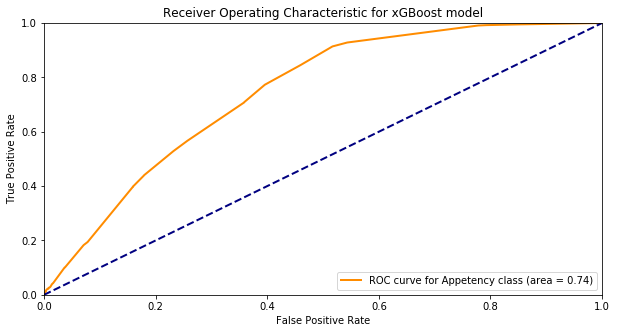

In [38]:
plot_roc_curve(y_test, y_score_xgb, "xGBoost")

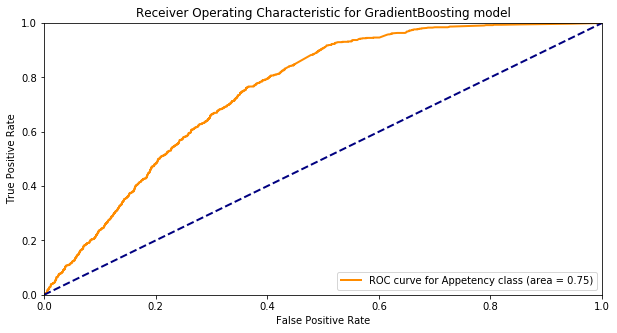

In [39]:
plot_roc_curve(y_test, y_score_gdb, "GradientBoosting")

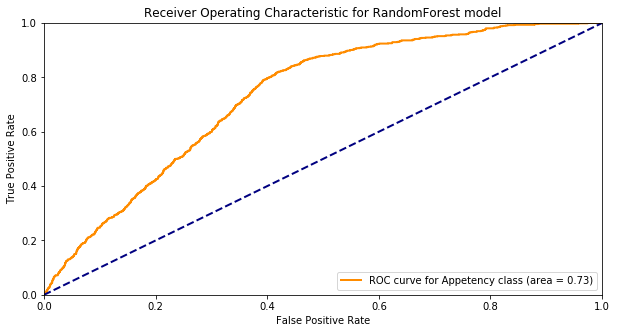

In [40]:
plot_roc_curve(y_test, y_score_rfc, "RandomForest")

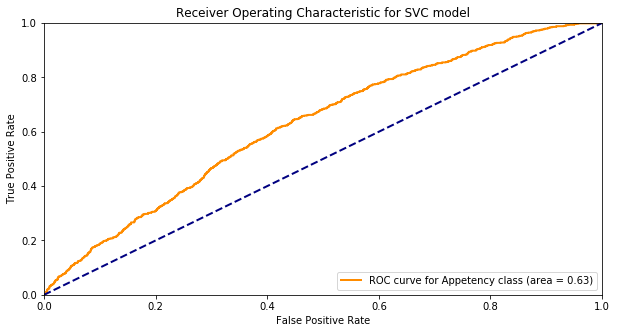

In [41]:
plot_roc_curve(y_test, y_score_svc, "SVC")

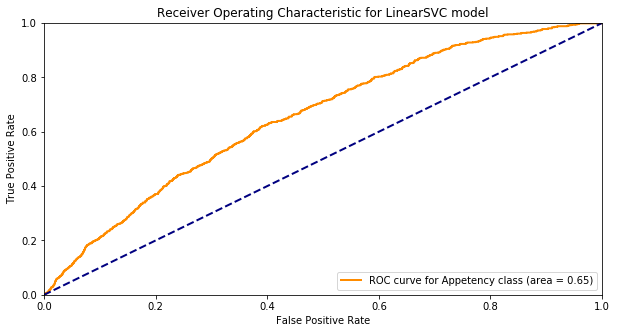

In [42]:
plot_roc_curve(y_test, y_score_lsvc, "LinearSVC")